In [1]:
import scipy.io
import numpy as np
#import casadi as ca
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.nn.modules.container import T
from tqdm import tqdm
from collections import defaultdict
from collections import OrderedDict
import random
from google.colab.patches import cv2_imshow
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
print(torch.cuda.is_available())

True


In [3]:
def get_odometry(data, angle, vx, vy, vz, wx, wy, wz, vel_control, steer_control, samples_i, samples_f):
    # Get size of the data
    i, j = data.shape
    # Init empty values
    x = np.zeros((1, j), dtype = np.double)
    y = np.zeros((1, j), dtype = np.double)
    z = np.zeros((1, j), dtype = np.double)
    quatenions = np.zeros((4, j), dtype = np.double)
    orientation_aux = np.zeros((3, j), dtype = np.double)

    for k in range(0, j):

        # Get Position
        x[:, k] = data[0, k]
        y[:, k] = data[1, k]
        z[:, k] = 0

        # Get quaternion
        quatenions[:, k] = [data[2, k], data[3, k], data[4, k], data[5, k]]

        # Get Euler Angles
        aux =  quatenions[:, k]
        r = R.from_quat(aux)
        orientation_aux[:, k] = r.as_euler('xyz', degrees = False)

    # get complete data of the system
    h = np.array([x[0,:], y[0,:], z[0,:],
                quatenions[0, :], quatenions[1, :], quatenions[2, :], quatenions[3, :],
                orientation_aux[0, :], orientation_aux[1, :], orientation_aux[2, :],
                angle[0, :]], dtype =np.double)

    # Get Velocities of the system
    hp = np.array([vx[0, :], vy[0, :], vz[0, :], wx[0, :], wy[0, :], wz[0, :]], dtype = np.double)
    T = np.array([vel_control[0,:], steer_control[0, :]], dtype = np.double)
    return h[:, samples_i:samples_f+1], hp[:, samples_i:samples_f+1], T[:, samples_i:samples_f]


In [4]:
def get_simple_data(h, hp, T):
    ## Position
    x = h[0, :]
    y = h[1, :]
    ## Linear velocities
    vx = hp[0, :]
    vy = hp[1, :]
    vz = hp[2, :]

    ## Get angular velocities
    p = hp[3, :]
    q = hp[4, :]
    r = hp[5, :]

    ## Angular velocities vector
    omega = hp[3:6, :]

    ## Orientacion
    quaternion = h[3:7, :]

    ##euler
    euler = h[7:10, :]

    ## Steer angle =
    alpha = h[10, :]

    ## General states data
    #X = np.array([euler[2,:], omega[2, :], alpha, vx, vy], dtype = np.double)
    #X = np.array([euler[0, :], euler[1, :], euler[2, :], omega[0, :], omega[1, :], omega[2, :], alpha, vx, vy, x, y], dtype = np.double)
    X = np.array([euler[2, :], omega[2, :], alpha, vx, vy, x, y], dtype = np.double)
    ## Control Action


    ## Get the dimension of the Data
    i, j = X.shape

    X1 = X[:, 0:j-1]
    X2 = X[:, 1:j]
    U_ref = T[:, 0:j-1]
    return X1, X2, U_ref

In [5]:
def liftFun(x):
    x_lift = []
    for k in x: x_lift.append(k)


    x_lift.append(np.cos(x[0, :])*x[3, :])
    x_lift.append(np.tan(x[2, :])*np.sin(x[0, :])*x[3, :])

    x_lift.append(np.sin(x[0, :])*x[3, :])
    x_lift.append(np.tan(x[2, :])*np.cos(x[0, :])*x[3, :])

    x_lift.append(1/(0.6 + np.tan(x[2, :])*np.tan(x[2, :])))

    x_lift.append(np.sin(x[0, :])*x[4, :])
    x_lift.append(np.tan(x[2, :])*np.cos(x[0, :])*x[4, :])

    #x_lift.append(np.cos(x[0, :])*x[4, :])
    #x_lift.append(np.tan(x[2, :])*np.sin(x[0, :])*x[4, :])


    #x_lift.append(x[3, :]*x[1, :])

    # Check this one
    #x_lift.append((np.tan(x[2, :]))/(0.6*np.cos(x[2, :])**2 + ((np.tan(x[2, :])**2)*(np.cos(x[2, :])**2))))


    x_lift = np.array(x_lift, dtype = np.double)
    return x_lift

In [6]:
def liftFun_vector(x):
    x_lift = []
    for k in x: x_lift.append(k)


    x_lift.append(np.cos(x[0])*x[3])
    x_lift.append(np.tan(x[2])*np.sin(x[0])*x[3])

    x_lift.append(np.sin(x[0])*x[3])
    x_lift.append(np.tan(x[2])*np.cos(x[0])*x[3])

    x_lift.append(1/(0.6 + np.tan(x[2])**2))

    x_lift.append(np.sin(x[0])*x[4])
    x_lift.append(np.tan(x[2])*np.cos(x[0])*x[4])

    #x_lift.append(np.cos(x[0])*x[4])
    #x_lift.append(np.tan(x[2])*np.sin(x[0])*x[4])

    #x_lift.append(x[3]*x[1])

    # Check this one
    #x_lift.append((np.tan(x[2]))/(0.6*np.cos(x[2])**2 + ((np.tan(x[2])**2)*(np.cos(x[2])**2))))

    x_lift = np.array(x_lift, dtype = np.double)
    return x_lift

In [7]:
## Reshape Data
## Load Matrices from mat file
Data = scipy.io.loadmat('blue_data_03.mat')

## Get odometry of the system
data_odom_blue = Data['data_odom_blue']
data_odom_blue = data_odom_blue.T

## Get Control steer angle
steering_control = Data['steering_control']
steering_control = steering_control.T
steering_control = steering_control*(np.pi/180)

## Get Steer angle real
steering_real = Data['steering_real']
steering_real = steering_real.T
steering_real = steering_real*(np.pi/180)

## Get system velocities
vx = Data['vx']
vx = vx.T
vy = Data['vy']
vy = vy.T
vz = Data['vz']
vz = vz.T
wx = Data['wx']
wx = wx.T
wy = Data['wy']
wy = wy.T
wz = Data['wz']
wz = wz.T

## Get desired frontal velocity

vel_control = Data['vel_control']
vel_control = vel_control.T

h1, hp1, T1 = get_odometry(data_odom_blue, steering_real, vx, vy, vz, wx, wy, wz, vel_control, steering_control, 0, 1000)

Data = scipy.io.loadmat('blue_data_02.mat')

## Get odometry of the system
data_odom_blue = Data['data_odom_blue']
data_odom_blue = data_odom_blue.T

## Get Control steer angle
steering_control = Data['steering_control']
steering_control = steering_control.T
steering_control = steering_control*(np.pi/180)

## Get Steer angle real
steering_real = Data['steering_real']
steering_real = steering_real.T
steering_real = steering_real*(np.pi/180)

## Get system velocities
vx = Data['vx']
vx = vx.T
vy = Data['vy']
vy = vy.T
vz = Data['vz']
vz = vz.T
wx = Data['wx']
wx = wx.T
wy = Data['wy']
wy = wy.T
wz = Data['wz']
wz = wz.T

## Get desired frontal velocity

vel_control = Data['vel_control']
vel_control = vel_control.T

h2, hp2, T2 = get_odometry(data_odom_blue, steering_real, vx, vy, vz, wx, wy, wz, vel_control, steering_control, 0, 1000)


## Get Data DMD
X1_n_1, X2_n_1, U_n_1 = get_simple_data(h1, hp1, T1)

X1_n_2, X2_n_2, U_n_2 = get_simple_data(h2, hp2, T2)

X1_n = np.hstack((X1_n_1, X1_n_2))
X2_n = np.hstack((X2_n_1, X2_n_2))
U_n = np.hstack((U_n_1, U_n_2))

n_normal = X1_n.shape[0]

# Koopman Space
X1 = liftFun(X1_n)
X2 = liftFun(X2_n)
U = U_n

n = X1.shape[0]
m = U.shape[0]

X1.shape[1]

2000

In [8]:
class koop_model(torch.nn.Module):
    def __init__(self, encode_layers, n, m, n_normal):
        super(koop_model,self).__init__()
        Layers = OrderedDict()
        for layer_i in range(len(encode_layers)-1):
            Layers["linear_{}".format(layer_i)] = nn.Linear(encode_layers[layer_i],encode_layers[layer_i+1])
            if layer_i != len(encode_layers)-2:
                Layers["relu_{}".format(layer_i)] = nn.Tanh()
        self.encode_net = nn.Sequential(Layers)
        self.Nkoopman = n
        self.u_dim = m

        self.A = nn.Linear(n, n,bias=False)
        self.A.weight.data = torch.eye(n)*0.1

        self.B = nn.Linear(m, n,bias=False)
        self.B.weight.data = torch.ones((n, m))

        self.C_eye = torch.eye(n_normal, device=device)
        self.C_zeros = torch.zeros((n_normal, n - n_normal), device=device)

        self.C= torch.cat((self.C_eye, self.C_zeros), dim=1)
        self.C = self.C.double()

    def encode(self,x):
        return torch.cat([x,self.encode_net(x)],axis=-1)

    #def forward(self,x,u):
        #return self.lA(x)+self.lB(u)
    def forward(self, X1, U):
        Gamma_1 = X1.T
        U = U.T

        output_1 = self.A(Gamma_1) + self.B(U)
        output_2 = (self.A(Gamma_1) + self.B(U))@self.C.T

        return output_1, output_2


In [9]:
def cost_koopman(X1, X2, U, net, P):

    x_k = X2.T@net.C.T
    Gamma_k = X2.T

    # output Neural Network
    output_koopman, output_prediction = net.forward(X1, U)

    # Get Error
    error_koop = Gamma_k - output_koopman
    #error_prediction = x_k - output_prediction

    #error_koop = error_koop

    Gamma_k_vector = Gamma_k.reshape((Gamma_k.shape[0]*Gamma_k.shape[1], 1))
    output_koopman_vector = output_koopman.reshape((output_koopman.shape[0]*output_koopman.shape[1], 1))

    error_koop_new = error_koop.reshape((error_koop.shape[0]*error_koop.shape[1], 1))

    loss =   1*torch.norm(error_koop_new, p='fro')

    return  loss

In [10]:
def Eig_loss(net):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    A = net.A.weight
    c = torch.linalg.eigvals(A).abs()-torch.ones(1,dtype=torch.float64).to(device)
    mask = c>0
    loss = c[mask].sum()
    return loss

In [11]:
## New Data in Pytorch
X1_tensor =  torch.tensor(X1,  requires_grad = True).to(device)
X1_tensor = X1_tensor.double()

X2_tensor =  torch.tensor(X2).to(device)
X2_tensor = X2_tensor.double()

U_tensor =  torch.tensor(U, requires_grad = True).to(device)
U_tensor =  U_tensor.double()
X1_tensor.shape

P = torch.zeros(1, X1.shape[1]).to(device)
P = P.double()
p = 1
for k in range(0, P.shape[1]):
  P[0, k] = p**(P.shape[1]- k)
P =  torch.diag(P[0, :])
print(P)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)


In [12]:
encode_dim = 20
layer_depth=3
layer_width = 128
layers = [n] + [layer_width]*layer_depth+[encode_dim]
Nkoopman = n + encode_dim
neural_network = koop_model(layers, n, m, n_normal)
if torch.cuda.is_available():
    print("Yes")
    neural_network.cuda()
neural_network.double()

Yes


koop_model(
  (encode_net): Sequential(
    (linear_0): Linear(in_features=14, out_features=128, bias=True)
    (relu_0): Tanh()
    (linear_1): Linear(in_features=128, out_features=128, bias=True)
    (relu_1): Tanh()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
    (relu_2): Tanh()
    (linear_3): Linear(in_features=128, out_features=20, bias=True)
  )
  (A): Linear(in_features=14, out_features=14, bias=False)
  (B): Linear(in_features=2, out_features=14, bias=False)
)

In [13]:
optimizer = torch.optim.Adam(neural_network.parameters(), lr=0.0001)

In [14]:
losses = defaultdict(lambda: defaultdict(list))
num_epochs = 10000
Kbatch_size = 100


In [15]:
losses = defaultdict(lambda: defaultdict(list))
num_epochs = 50000
Kbatch_size = 400
#aux = neural_network.encode(X1_tensor[0:6, :].T)
#aux_x = neural_network.B(U_tensor[:,:].T)

aux = neural_network.encode(X1_tensor.T)
aux.shape

torch.Size([2000, 34])

In [16]:
for epoch in tqdm(range(num_epochs), desc="Koopman Neural Network: training epoch"):
        #loss.backward(retain_graph = True)
        #loss.backward(retain_graph = True)
        Kindex = list(range(X1_tensor.shape[1]))
        random.shuffle(Kindex)


        Kloss = cost_koopman(X1_tensor, X2_tensor, U_tensor, neural_network, P)
        Keig = Eig_loss(neural_network)
        loss = Kloss + 3*Keig

        # Optimize Network
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()


        losses["Koopman"]["collocation"].append(loss.item())
        losses["Koopman"]["num_epochs"].append(epoch)


Koopman Neural Network: training epoch: 100%|██████████| 50000/50000 [03:32<00:00, 234.93it/s]


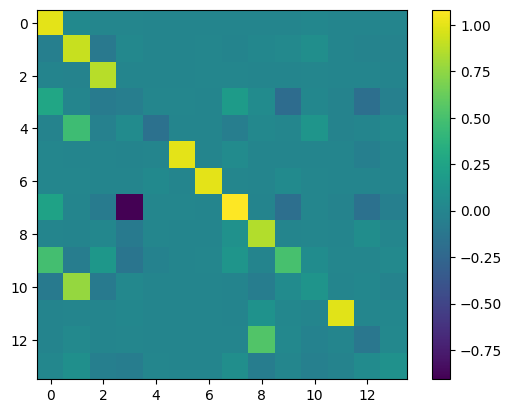

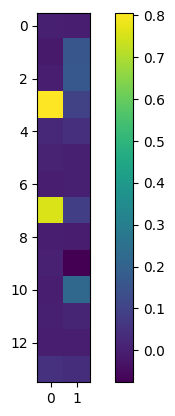

Error estimation norm
205.08880351657098
 Eigvalues A
[-0.15125936+0.j         -0.16963448+0.j          0.04483711+0.j
  0.10760595+0.00798403j  0.10760595-0.00798403j  0.51587344+0.j
  0.86787359+0.j          0.90330289+0.07089168j  0.90330289-0.07089168j
  0.98843638+0.02546735j  0.98843638-0.02546735j  0.99300025+0.j
  0.99992508+0.00072684j  0.99992508-0.00072684j]
 Determinan A
4.778968610036263e-06
Matrix P Conditioned
tensor(579499.9913, device='cuda:0', dtype=torch.float64,
       grad_fn=<DivBackward0>)
Matrix P Determinat
tensor(1.8281e+28, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgDetBackward0>)


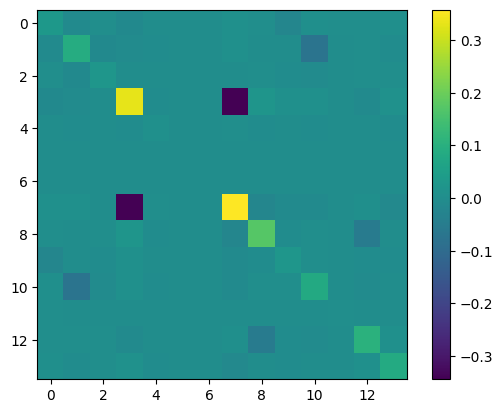

In [28]:
## Reshape Data
## Load Matrices from mat file
Data = scipy.io.loadmat('blue_data_03.mat')

## Get odometry of the system
data_odom_blue = Data['data_odom_blue']
data_odom_blue = data_odom_blue.T

## Get Control steer angle
steering_control = Data['steering_control']
steering_control = steering_control.T
steering_control = steering_control*(np.pi/180)

## Get Steer angle real
steering_real = Data['steering_real']
steering_real = steering_real.T
steering_real = steering_real*(np.pi/180)

## Get system velocities
vx = Data['vx']
vx = vx.T
vy = Data['vy']
vy = vy.T
vz = Data['vz']
vz = vz.T
wx = Data['wx']
wx = wx.T
wy = Data['wy']
wy = wy.T
wz = Data['wz']
wz = wz.T

## Get desired frontal velocity

vel_control = Data['vel_control']
vel_control = vel_control.T

h1, hp1, T1 = get_odometry(data_odom_blue, steering_real, vx, vy, vz, wx, wy, wz, vel_control, steering_control, 0, 1000)

Data = scipy.io.loadmat('blue_data_02.mat')

## Get odometry of the system
data_odom_blue = Data['data_odom_blue']
data_odom_blue = data_odom_blue.T

## Get Control steer angle
steering_control = Data['steering_control']
steering_control = steering_control.T
steering_control = steering_control*(np.pi/180)

## Get Steer angle real
steering_real = Data['steering_real']
steering_real = steering_real.T
steering_real = steering_real*(np.pi/180)

## Get system velocities
vx = Data['vx']
vx = vx.T
vy = Data['vy']
vy = vy.T
vz = Data['vz']
vz = vz.T
wx = Data['wx']
wx = wx.T
wy = Data['wy']
wy = wy.T
wz = Data['wz']
wz = wz.T

## Get desired frontal velocity

vel_control = Data['vel_control']
vel_control = vel_control.T

h2, hp2, T2 = get_odometry(data_odom_blue, steering_real, vx, vy, vz, wx, wy, wz, vel_control, steering_control, 0, 1200)


## Get Data DMD
X1_n_1, X2_n_1, U_n_1 = get_simple_data(h1, hp1, T1)

X1_n_2, X2_n_2, U_n_2 = get_simple_data(h2, hp2, T2)

X1_n = X1_n_2
X2_n = X2_n_2
U_n = U_n_2


n_normal = X1_n.shape[0]

# Koopman Space
X1 = liftFun(X1_n)
X2 = liftFun(X2_n)
U = U_n

n = X1.shape[0]
m = U.shape[0]


X1_tensor =  torch.tensor(X1,  requires_grad = True).to(device)
X1_tensor = X1_tensor.double()

X2_tensor =  torch.tensor(X2).to(device)
X2_tensor = X2_tensor.double()

U_tensor =  torch.tensor(U, requires_grad = True).to(device)
U_tensor =  U_tensor.double()

A_a = neural_network.A.weight.cpu()
A_a = A_a.double()
A_a = A_a.detach().numpy()

B_a = neural_network.B.weight.cpu()
B_a = B_a.double()
B_a = B_a.detach().numpy()

C_ones = np.eye(n_normal, dtype = np.double)
C_zeros = np.zeros((n_normal, n - n_normal), dtype=np.double)
C_a = np.hstack((C_ones, C_zeros))

## Plot matrix A
plt.imshow(A_a)
plt.colorbar()
plt.show()
#
# Plot matrix B
plt.imshow(B_a)
plt.colorbar()
plt.show()
#
# New variables in order to verify the identification
x_estimate = np.zeros((n_normal, X1.shape[1]+1), dtype=np.double)
output_estimate = np.zeros((n_normal, U.shape[1]), dtype=np.double)
output_real = np.zeros((n_normal, U.shape[1]), dtype=np.double)
error_vector = np.zeros((n_normal, U.shape[1]), dtype=np.double)
norm_error = np.zeros((1, U.shape[1]), dtype = np.double)

# Initial value
x_estimate[:, 0] = C_a@X1[:, 0]

for k in range(0, U.shape[1]):
    output_estimate[:, k] = x_estimate[:, k]
    output_real[:, k] = C_a@X1[:, k]

    error_vector[:, k] = output_real[:, k] - output_estimate[:, k]
    norm_error[:, k] = np.linalg.norm(error_vector[:, k])

    aux_states = liftFun_vector(x_estimate[:, k])
    x_estimate[:, k+1] = C_a@(A_a@aux_states + B_a@U[:, k])

# Check error of the identified system
print("Error estimation norm")
print(np.linalg.norm(norm_error))

# Check Eig values amtrix A
eig_A, eigv_A = np.linalg.eig(A_a)
deter = np.linalg.det(A_a)
print(" Eigvalues A")
print(eig_A)
print(" Determinan A")
print(deter)

# Get Covarianza matrix of the system
X_lift = (X1_tensor.T)
aux_inverse = torch.inverse(X_lift.T@X_lift)
U, S, V = torch.svd(aux_inverse)

# get Condition number Covariance matrix
condition_number = torch.max(S) / torch.min(S)
print('Matrix P Conditioned')
print(condition_number)

# Plot Covariance matrix
aux_inverse  = aux_inverse.cpu().detach().numpy()
plt.imshow(aux_inverse)
plt.colorbar()

# get determinant of the covariance matrix
det_P = torch.det((X_lift.T@X_lift))
print('Matrix P Determinat')
print(det_P)


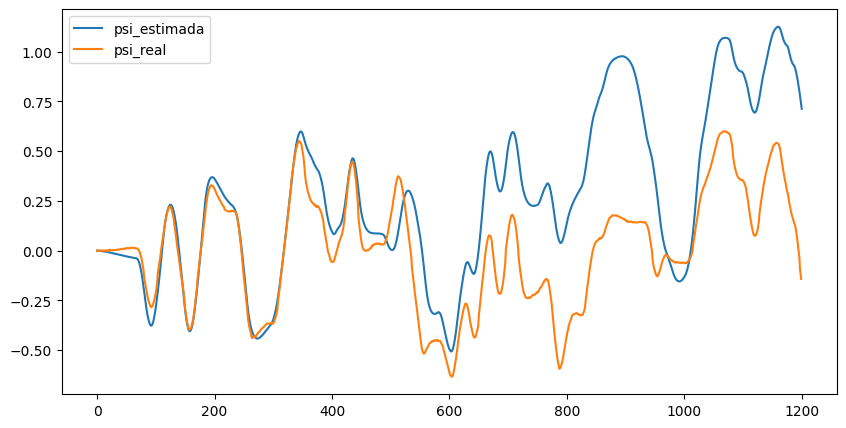

In [29]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

# Plot x_estimate with label 'x_estimate'
ax1.plot(x_estimate[0, :], label='psi_estimada')

# Plot h with label 'h'
ax1.plot(X1[0, 0:X1.shape[1]+1], label='psi_real')

# Add a legend
ax1.legend()

# Show the plot
plt.show()

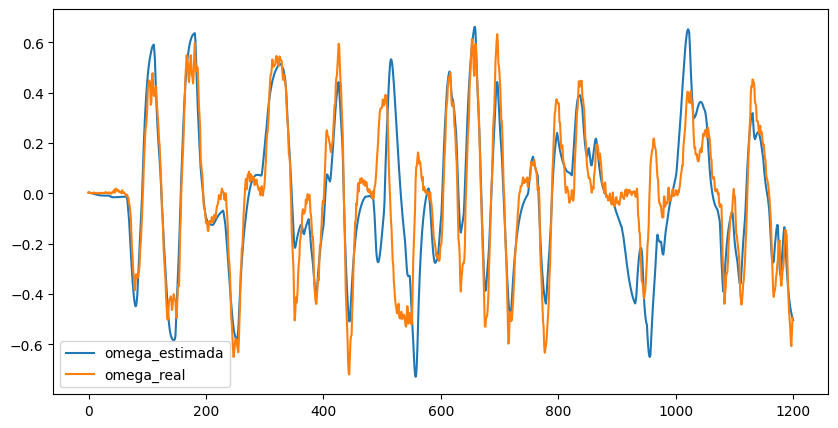

In [30]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

# Plot x_estimate with label 'x_estimate'
ax1.plot(x_estimate[1, :], label='omega_estimada')

# Plot h with label 'h'
ax1.plot(X1[1, 0:X1.shape[1]+1], label='omega_real')

# Add a legend
ax1.legend()

# Show the plot
plt.show()

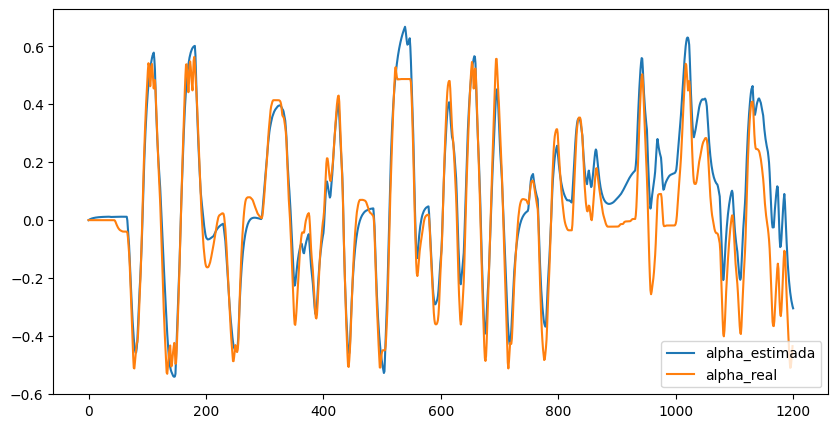

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

# Plot x_estimate with label 'x_estimate'
ax1.plot(x_estimate[2, :], label='alpha_estimada')

# Plot h with label 'h'
ax1.plot(X1[2, 0:X1.shape[1]+1], label='alpha_real')

# Add a legend
ax1.legend()

# Show the plot
plt.show()

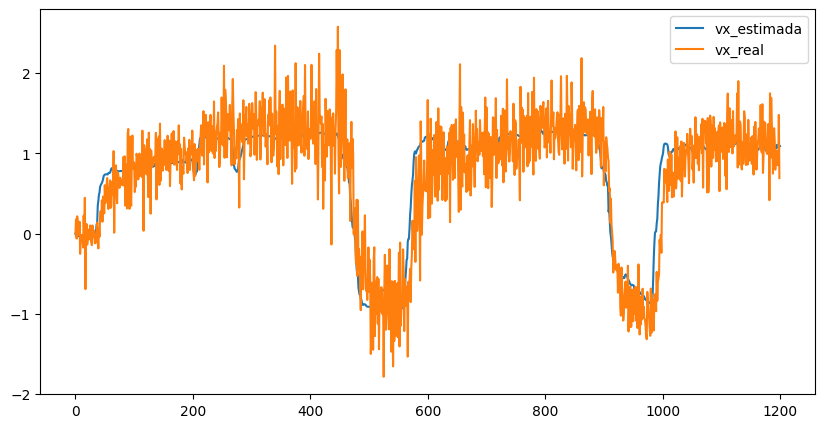

In [32]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

# Plot x_estimate with label 'x_estimate'
ax1.plot(x_estimate[3, :], label='vx_estimada')

# Plot h with label 'h'
ax1.plot(X1[3, 0:X1.shape[1]+1], label='vx_real')

# Add a legend
ax1.legend()

# Show the plot
plt.show()

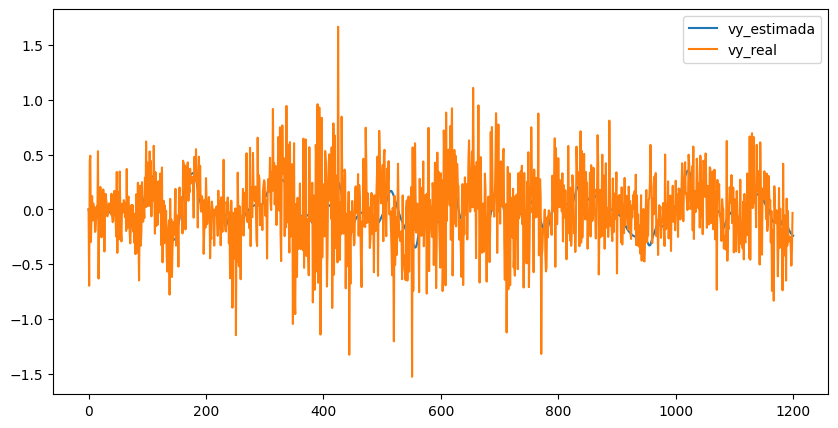

In [33]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

# Plot x_estimate with label 'x_estimate'
ax1.plot(x_estimate[4, :], label='vy_estimada')

# Plot h with label 'h'
ax1.plot(X1[4, 0:X1.shape[1]+1], label='vy_real')

# Add a legend
ax1.legend()

# Show the plot
plt.show()

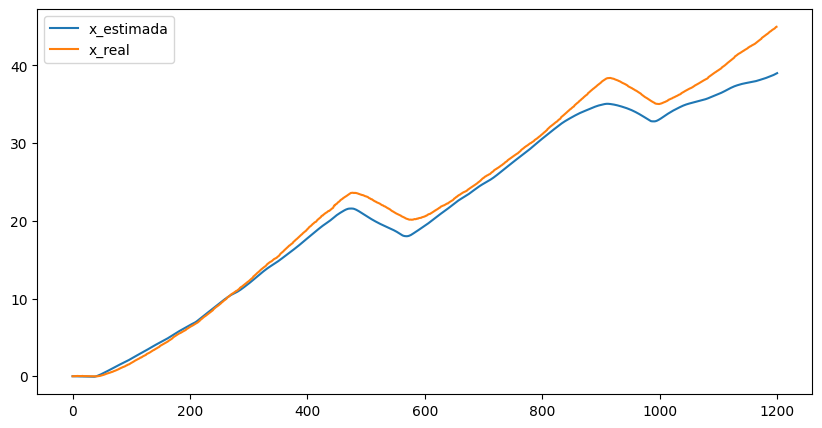

In [34]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

# Plot x_estimate with label 'x_estimate'
ax1.plot(x_estimate[5, :], label='x_estimada')

# Plot h with label 'h'
ax1.plot(X1[5, 0:X1.shape[1]+1], label='x_real')

# Add a legend
ax1.legend()

# Show the plot
plt.show()

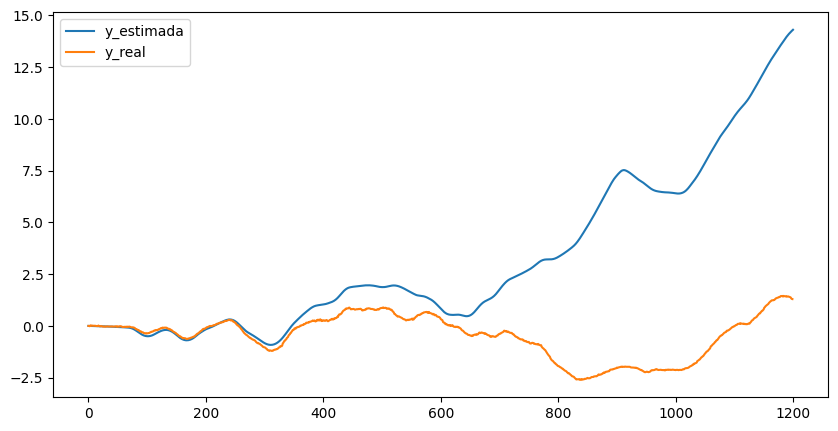

In [35]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

# Plot x_estimate with label 'x_estimate'
ax1.plot(x_estimate[6, :], label='y_estimada')

# Plot h with label 'h'
ax1.plot(X1[6, 0:X1.shape[1]+1], label='y_real')

# Add a legend
ax1.legend()

# Show the plot
plt.show()

In [36]:
losses["Koopman"]["collocation"]
costo = np.array(losses["Koopman"]["collocation"])
epochs = np.array(losses["Koopman"]["num_epochs"])
costo = costo.reshape(1, costo.shape[0])
costo

array([[1052.11325987, 1051.92247235, 1051.73189994, ...,   29.50621798,
          29.50668343,   29.50631842]])

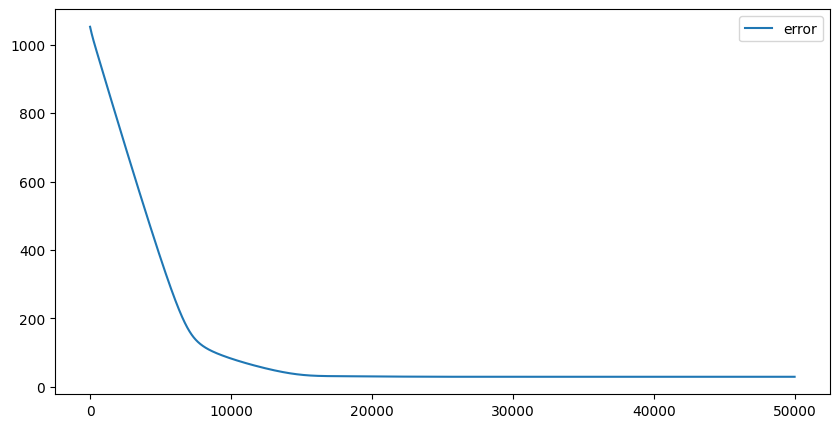

In [37]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

# Plot x_estimate with label 'x_estimate'
ax1.plot(costo[0,:], label='error')


# Add a legend
ax1.legend()

# Show the plot
plt.show()

In [27]:
300*0.05

15.0